In [5]:


import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raulonlab/crypto-band-indicators#egg=crypto_band_indicators

import backtrader as bt
from crypto_band_indicators import TickerDataSource, FngWeightedAverageStrategy, FngRebalanceStrategy
from crypto_band_indicators.utils.utils import LogColors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200

# Fear and Greed Simulator

Usage...

### Variables

In [9]:
# Strategy variables
strategy             = "rebalance"    # Select strategy between "weighted_dca" and "rebalance"
ticker_symbol        = "BTCUSDT"      # currently only works with BTCUSDT
start                = '01/01/2022'   # start date of the simulation. Ex: '01/08/2020' or None
end                  = '30/05/2022'           # end date of the simulation. Ex: '01/08/2020' or None
initial_cash         = 10000.0        # initial broker cash. Default 10000 usd
min_order_period     = 5              # Minimum period in days to place orders
base_buy_amount      = 100            # Amount purchased in standard DCA
weighted_multipliers = [1.5, 1.25, 1, 0.75, 0.5]    # buy amount multipliers (weighted) for each band
rebalance_percents   = [85, 65, 50, 15, 10]         # rebalance percentages of BTC / total for each band

### Run Simulator!

In [10]:
cerebro = bt.Cerebro(stdstats=True, runonce=True)
cerebro.broker.set_coc(True)

# Data sources
ticker_data_source = TickerDataSource()

# Add data feeds to Cerebro
simulation_data_feed = ticker_data_source.to_backtrade_feed(start, end)
cerebro.adddata(simulation_data_feed)

# Add strategies
if strategy == "weighted_dca":
    cerebro.addstrategy(FngWeightedAverageStrategy, base_buy_amount=base_buy_amount,
                    min_order_period=min_order_period, weighted_multipliers=weighted_multipliers, log=True)
elif strategy == "rebalance":
    cerebro.addstrategy(FngRebalanceStrategy, min_order_period=min_order_period, rebalance_percents=rebalance_percents, log=True)
else:
    error_message = f"Invalid strategy: '{strategy}'"
    print(f"Error: {error_message}")
    exit()


# Add cash to the virtual broker
cerebro.broker.setcash(initial_cash)    # default: 10k

start_portfolio_value = cerebro.broker.getvalue()
cerebro_results = cerebro.run()

end_cash = cerebro.broker.getcash()
end_portfolio_value = cerebro.broker.getvalue()     # Total value in USDT
end_position = cerebro.getbroker().getposition(data=simulation_data_feed)
start_btc_price, end_btc_price = ticker_data_source.get_value_start_end(
    start=start, end=end)

pnl_value = end_portfolio_value - start_portfolio_value
pnl_percent = (pnl_value / start_portfolio_value) * 100
pnl_color = f"{LogColors.FAIL}" if end_portfolio_value < start_portfolio_value else f"{LogColors.OK}"

print("\nSIMULATION RESULT")
print("------------------------")
print(f"{'Started:':<8} {start_portfolio_value:>10.2f} USD (1 BTC = {start_btc_price:.2f} USD)")
print(f"{'Ended:':<8} {end_portfolio_value:>10.2f} USD ({end_position.size:6f} BTC + {end_cash:.2f} USD in cash | 1 BTC = {end_btc_price:.2f} USD)")
print(f"{'PnL:':<8} {pnl_color}{pnl_value:>10.2f} USD ({pnl_percent:.2f}%){LogColors.ENDC}")



2022-01-01: R REBALANCE (FIRST). Current FnG: 1, No previous FnG
2022-01-01: B BUY 0.183786 BTC = 8500.00 USD, 1 BTC = 46249.56 USD
2022-01-02:   BUY COMPLETED, size: 0.183786 BTC = 8500.00 USD, comm 0.00, 1 BTC = 46249.56 USD
2022-01-30: R REBALANCE. Current FnG: 2, Previous FnG: 1
2022-01-30: S SELL -0.038792 BTC = -1481.34 USD, 1 BTC = 38186.49 USD
2022-01-31:   SELL COMPLETED, size: -0.038792 BTC = 1794.13 USD, comm 0.00, 1 BTC = 38186.49 USD
2022-02-04: R REBALANCE. Current FnG: 1, Previous FnG: 2
2022-02-04: B BUY 0.046571 BTC = 1727.42 USD, 1 BTC = 37092.40 USD
2022-02-05:   BUY COMPLETED, size: 0.046571 BTC = 1727.42 USD, comm 0.00, 1 BTC = 37092.40 USD
2022-02-09: R REBALANCE. Current FnG: 3, Previous FnG: 1
2022-02-09: S SELL -0.081576 BTC = -3600.21 USD, 1 BTC = 44133.28 USD
2022-02-10:   SELL COMPLETED, size: -0.081576 BTC = 3591.25 USD, comm 0.00, 1 BTC = 44133.28 USD
2022-02-18: R REBALANCE. Current FnG: 2, Previous FnG: 3
2022-02-18: B BUY 0.039284 BTC = 1593.58 USD, 1 B

### Plot results

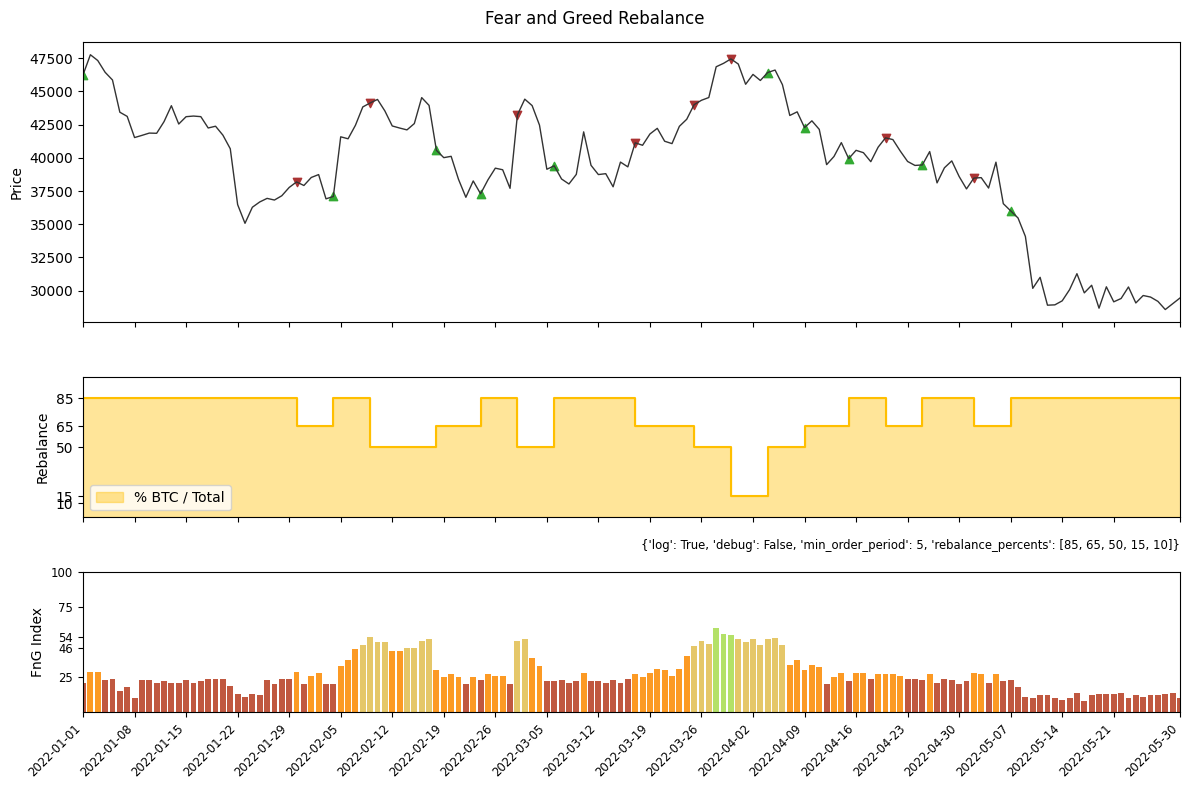

In [11]:
enable_plot_results = True   # Set True to plot the simulation results

if enable_plot_results:
   if len(cerebro_results) > 0:
        cerebro_results[0].plot()
